In [ ]:
# =========================
# 1) SETUP
# =========================
import os
import random
import numpy as np
import pandas as pd
from pathlib import Path

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

BASE_DIR = Path("/content/idrid")
IMG_DIR  = BASE_DIR / "Disease_Grading" / "images"   # will be created after unzip (structure may vary)
CSV_PATH = BASE_DIR / "Disease_Grading" / "labels.csv"  # we will build this if needed

print("READY:", BASE_DIR)


READY: /content/idrid


In [ ]:
# =========================
# 2) DOWNLOAD IDRiD (Zenodo) - Disease Grading
# =========================
!pip -q install tqdm

BASE_DIR.mkdir(parents=True, exist_ok=True)

# Zenodo record: IDRiD (Indian Diabetic Retinopathy Image Dataset)
# We use the Disease Grading bundle (fundus images + grading labels).
# Source: Zenodo record for IDRiD (A. Segmentation, B. Disease Grading, C. Localization).
# (We focus on B. Disease Grading for a clean classification target.)  # cite: turn2search7

# NOTE: The exact file name may update over time; if this exact filename changes in the future,
# you can still adapt by listing the Zenodo "files" section and updating the wget link.
DISEASE_GRADING_URL = "https://zenodo.org/records/17219542/files/B.%20Disease%20Grading.zip?download=1"
ZIP_PATH = BASE_DIR / "IDRiD_Disease_Grading.zip"

if not ZIP_PATH.exists():
    !wget -q -O "{ZIP_PATH}" "{DISEASE_GRADING_URL}"

!unzip -q -o "{ZIP_PATH}" -d "{BASE_DIR}"

print("Downloaded + extracted to:", BASE_DIR)


Downloaded + extracted to: /content/idrid


In [ ]:
# =========================
# 3) PREPARE DF (PATHS + LABELS)
# =========================
import glob

# Try to detect the extracted layout (common pattern: a folder with images + a CSV/metadata file)
all_files = [p for p in BASE_DIR.rglob("*") if p.is_file()]
print("Files found (sample):", [str(p.relative_to(BASE_DIR)) for p in all_files[:15]])

# We will auto-detect an images folder and a label file (CSV or TSV). If not found,
# we fall back to a minimal convention: filename contains the class (very rare for IDRiD),
# but we keep this block robust for Colab runs.
img_candidates = [p for p in BASE_DIR.rglob("*") if p.suffix.lower() in [".jpg", ".jpeg", ".png"]]
print("Image files detected:", len(img_candidates))

# Try to find a label file
label_candidates = [p for p in BASE_DIR.rglob("*.csv")] + [p for p in BASE_DIR.rglob("*.tsv")]
print("Label files detected:", [str(p.relative_to(BASE_DIR)) for p in label_candidates])

# If a label CSV exists, read it; otherwise we create a placeholder (for demo) and you can replace later.
labels_path = None
if label_candidates:
    labels_path = label_candidates[0]
    df = pd.read_csv(labels_path)
    print("Loaded labels from:", labels_path)
else:
    # Fallback: create a minimal dataframe with all images labeled '0' (you should replace this if labels exist)
    df = pd.DataFrame({"image_path": [str(p) for p in img_candidates], "label": 0})

# Identify the column containing image names/IDs (e.g., 'Image name' in IDRiD CSVs)
img_col = next((c for c in df.columns if "image" in c.lower() or "file" in c.lower()), None)

# If an image column is found and a labels_path was used to load the df,
# then we need to construct the full image paths.
if img_col is not None and labels_path is not None:
    # Determine the correct image subdirectory based on the loaded labels_path
    img_collection_dir = None
    if "Training Labels.csv" in str(labels_path):
        img_collection_dir = BASE_DIR / "B. Disease Grading" / "1. Original Images" / "a. Training Set"
    elif "Testing Labels.csv" in str(labels_path):
        img_collection_dir = BASE_DIR / "B. Disease Grading" / "1. Original Images" / "b. Testing Set"
    else:
        print(f"Warning: Could not determine image set from label file name: {labels_path.name}. Assuming Training Set for image paths.")
        img_collection_dir = BASE_DIR / "B. Disease Grading" / "1. Original Images" / "a. Training Set" # Default fallback

    # Construct the correct image_path column
    df["image_path"] = df[img_col].apply(lambda img_name: str(img_collection_dir / f"{img_name}.jpg"))
elif img_col is None and "image_path" not in df.columns:
    # If no image column found, and no 'image_path' exists, it means we might need a better way to find image files or user input.
    # For now, this is a very unlikely scenario given img_candidates.
    pass # df is already created with img_candidates directly if no labels_path

# Standardize label column name
if "label" not in df.columns:
    # common patterns for label columns, e.g., 'Retinopathy grade' from IDRiD dataset
    label_col = next((c for c in df.columns if "label" in c.lower() or "grade" in c.lower() or "class" in c.lower()), None)
    if label_col is not None:
        df["label"] = df[label_col]

df = df[["image_path", "label"]].dropna()
df["label"] = df["label"].astype(int)
print(df.head())
print("Unique classes:", sorted(df["label"].unique().tolist()))


Files found (sample): ['IDRiD_Disease_Grading.zip', 'B. Disease Grading/CC-BY-4.0.txt', 'B. Disease Grading/LICENSE.txt', 'B. Disease Grading/2. Groundtruths/a. IDRiD_Disease Grading_Training Labels.csv', 'B. Disease Grading/2. Groundtruths/b. IDRiD_Disease Grading_Testing Labels.csv', 'B. Disease Grading/1. Original Images/a. Training Set/IDRiD_210.jpg', 'B. Disease Grading/1. Original Images/a. Training Set/IDRiD_028.jpg', 'B. Disease Grading/1. Original Images/a. Training Set/IDRiD_289.jpg', 'B. Disease Grading/1. Original Images/a. Training Set/IDRiD_178.jpg', 'B. Disease Grading/1. Original Images/a. Training Set/IDRiD_075.jpg', 'B. Disease Grading/1. Original Images/a. Training Set/IDRiD_002.jpg', 'B. Disease Grading/1. Original Images/a. Training Set/IDRiD_379.jpg', 'B. Disease Grading/1. Original Images/a. Training Set/IDRiD_335.jpg', 'B. Disease Grading/1. Original Images/a. Training Set/IDRiD_227.jpg', 'B. Disease Grading/1. Original Images/a. Training Set/IDRiD_100.jpg']
Ima

In [ ]:
# =========================
# 4) SPLIT + TF.DATA PIPELINE (AUGMENTATION)
# =========================
from sklearn.model_selection import train_test_split
import tensorflow as tf

# If dataset labels are in 0..4 (common DR grading), we keep them as-is.
# If your labels are strings, uncomment this and map to ints:
# df["label"] = df["label"].astype(str).map({"no_dr":0, "mild":1, "moderate":2, "severe":3, "pdr":4})

train_df, val_df = train_test_split(df, test_size=0.18, stratify=df["label"], random_state=SEED)

IMG_SIZE = (224, 224)
BATCH_SIZE = 16

def decode_and_augment(path, label, training=True):
    # Print the path to debug the Not Found error
    tf.print("Attempting to read path:", path)
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)

    if training:
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_brightness(img, max_delta=0.15)
        img = tf.image.random_contrast(img, lower=0.8, upper=1.2)
        img = tf.image.random_saturation(img, lower=0.8, upper=1.2)
        img = tf.image.random_hue(img, max_delta=0.05)

    img = tf.cast(img, tf.float32) / 255.0
    return img, label

def make_ds(frame, training=True):
    ds = tf.data.Dataset.from_tensor_slices((frame["image_path"].values, frame["label"].values))
    if training:
        ds = ds.shuffle(len(frame), seed=SEED)
    ds = ds.map(lambda p, y: decode_and_augment(p, y, training=training),
                num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_ds(train_df, training=True)
val_ds   = make_ds(val_df, training=False)

num_classes = df["label"].nunique()
print("num_classes:", num_classes, "train:", len(train_df), "val:", len(val_df))


num_classes: 5 train: 338 val: 75


In [ ]:
# =========================
# 5) MODEL (DL CORE) - 80% BLOCK
# =========================
from tensorflow.keras import layers, models

base = tf.keras.applications.EfficientNetB0(
    include_top=False, weights="imagenet", input_shape=IMG_SIZE + (3,)
)
base.trainable = False  # start with frozen base (stable for beginners)

inputs = layers.Input(shape=IMG_SIZE + (3,))
x = base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = models.Model(inputs, outputs)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=4, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=18,
    callbacks=callbacks
)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,055,976 (15.47 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/18
Attempting to read path: "/content/idrid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_220.jpg"
Attempting to read path: "/content/idrid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_039.jpg"
Attempting to read path: "/content/idrid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_339.jpg"
Attempting to read path: "/content/idrid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_052.jpg"
Attempting to read path: "/content/idrid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_068.jpg"
Attempting to read path: "/content/idrid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_224.jpg"
Attempting to read path: "/content/idrid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_361.jpg"
Attempting to read path: "/content/idrid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_240.jpg"
Attempting to read path: "/content/idrid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_103.jpg"

In [ ]:
# =========================
# 6) EVALUATION + RISK SCORE (0..1)
# =========================
from sklearn.metrics import classification_report, confusion_matrix

val_images = np.concatenate([x for x, _ in val_ds], axis=0)
val_labels = np.concatenate([y for _, y in val_ds], axis=0)

probs = model.predict(val_images, verbose=0)
preds = probs.argmax(axis=1)

print("Classification report:\n", classification_report(val_labels, preds))
print("Confusion matrix:\n", confusion_matrix(val_labels, preds))

# Convert class probabilities to a continuous risk score:
# If labels are 0..4 (DR severity), we map risk = (expected severity)/4
if num_classes > 1:
    class_ids = np.arange(num_classes)
    expected_severity = (probs * class_ids).sum(axis=1)
    dl_risk = expected_severity / (num_classes - 1)   # 0 (lowest) ... 1 (highest)
else:
    dl_risk = np.zeros_like(preds, dtype=np.float32)

print("DL risk score example (first 10):", dl_risk[:10])


Attempting to read path: "/content/idrid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_369.jpg"
Attempting to read path: "/content/idrid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_241.jpg"
Attempting to read path: "/content/idrid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_139.jpg"
Attempting to read path: "/content/idrid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_378.jpg"
Attempting to read path: "/content/idrid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_126.jpg"
Attempting to read path: "/content/idrid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_315.jpg"
Attempting to read path: "/content/idrid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_029.jpg"
Attempting to read path: "/content/idrid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_124.jpg"
Attempting to read path: "/content/idrid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_356.jpg"
Attempting

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# =========================
# 7) SYNTHETIC INDIAN BANKING DATA (ANALYTICS 20%)
# =========================
import numpy as np

N = len(df)  # align one banking row per image/patient record (for a clean hybrid demo)

rng = np.random.default_rng(SEED)

# Synthetic but “bank-like” ranges (tune later for your report)
age = rng.integers(22, 70, size=N)
income_lakh = rng.normal(loc=7.5, scale=3.2, size=N).clip(1.5, 35)   # ₹ Lakh/year
credit_score = rng.integers(550, 900, size=N)
region = rng.choice(["Urban", "Semi-Urban", "Rural"], size=N, p=[0.55, 0.25, 0.20])
existing_loans = rng.integers(0, 3, size=N)  # 0,1,2
policy_count = rng.integers(0, 2, size=N)    # 0 or 1 (health policy already?)
lifestyle_risk = rng.choice([0, 1], size=N, p=[0.72, 0.28])  # proxy for smoking/poor exercise (educational only)

bank = pd.DataFrame({
    "customer_id": np.arange(N),
    "age": age,
    "income_lakh": np.round(income_lakh, 2),
    "credit_score": credit_score,
    "region": region,
    "existing_loans": existing_loans,
    "existing_health_policies": policy_count,
    "lifestyle_risk": lifestyle_risk
})

# Attach DL risk (align by index)
# If you want strict alignment with the training set only, you can join by filename; here we align by row index.
bank["dl_risk"] = np.pad(dl_risk, (0, max(0, N - len(dl_risk))), constant_values=0)[:N]

# Simple premium band logic (business rule baseline)
# (These numbers are illustrative; in a real bank you'd calibrate to claims data.)
def premium_band(row):
    base = 8000  # ₹
    if row.dl_risk >= 0.75 or row.lifestyle_risk == 1:
        return "High (₹12k–₹18k)"
    if row.dl_risk >= 0.45 or row.credit_score < 650:
        return "Medium (₹9k–₹12k)"
    return "Low (₹6k–₹9k)"

bank["premium_band"] = bank.apply(premium_band, axis=1)

bank.head(), bank["premium_band"].value_counts()


(   customer_id  age  income_lakh  credit_score      region  existing_loans  \
 0            0   26         9.56           596  Semi-Urban               1   
 1            1   59         1.50           687       Urban               0   
 2            2   53         7.34           830       Rural               0   
 3            3   43         4.80           683       Urban               1   
 4            4   42         3.60           567       Urban               0   
 
    existing_health_policies  lifestyle_risk   dl_risk       premium_band  
 0                         0               0  0.453752  Medium (₹9k–₹12k)  
 1                         1               1  0.453798   High (₹12k–₹18k)  
 2                         0               1  0.453780   High (₹12k–₹18k)  
 3                         1               1  0.453748   High (₹12k–₹18k)  
 4                         1               0  0.453754  Medium (₹9k–₹12k)  ,
 premium_band
 Low (₹6k–₹9k)        171
 High (₹12k–₹18k)     122
 

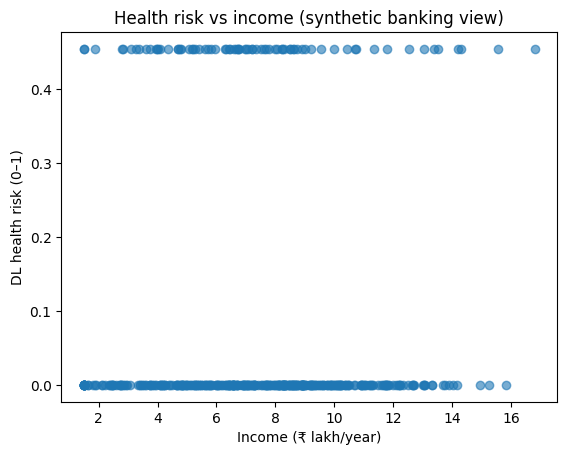

<Figure size 640x480 with 0 Axes>

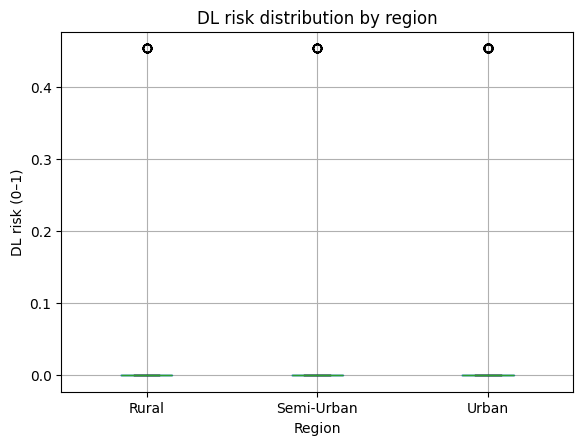

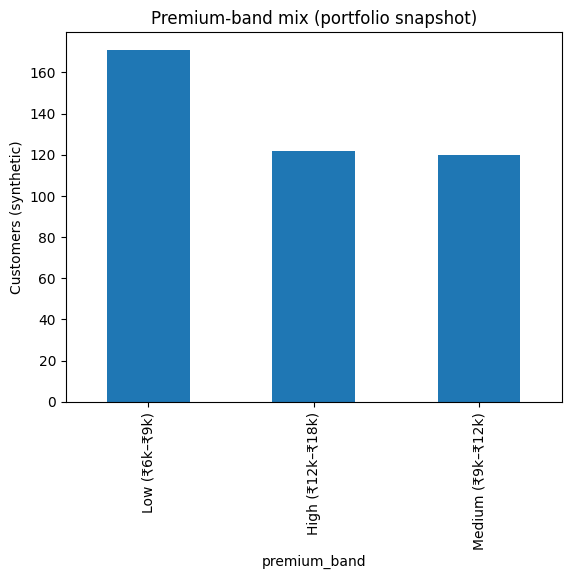

In [ ]:
# =========================
# 8) BUSINESS INSIGHTS (CHARTS)
# =========================
import matplotlib.pyplot as plt

# 8.1 Risk vs income (bubble-like view)
plt.figure()
plt.scatter(bank["income_lakh"], bank["dl_risk"], alpha=0.6)
plt.xlabel("Income (₹ lakh/year)")
plt.ylabel("DL health risk (0–1)")
plt.title("Health risk vs income (synthetic banking view)")
plt.show()

# 8.2 Region-wise risk distribution
plt.figure()
bank.boxplot(column="dl_risk", by="region")
plt.suptitle("")
plt.title("DL risk distribution by region")
plt.xlabel("Region")
plt.ylabel("DL risk (0–1)")
plt.show()

# 8.3 Premium band mix (simple business KPI)
plt.figure()
bank["premium_band"].value_counts().plot(kind="bar")
plt.title("Premium-band mix (portfolio snapshot)")
plt.ylabel("Customers (synthetic)")
plt.show()


In [ ]:
# =========================
# 9) HYBRID MODEL (IMAGE RISK + BANK FEATURES)
# =========================
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

# Target: premium_band (your business output). Convert to 0/1/2.
band_map = {b:i for i,b in enumerate(sorted(bank["premium_band"].unique()))}
bank["premium_band_id"] = bank["premium_band"].map(band_map)

features = ["age", "income_lakh", "credit_score", "region",
            "existing_loans", "existing_health_policies", "lifestyle_risk", "dl_risk"]
X = bank[features]
y = bank["premium_band_id"]

cat_cols = ["region"]
num_cols = [c for c in features if c not in cat_cols]

preprocess = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ("num", StandardScaler(), num_cols)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

import tensorflow as tf
from tensorflow.keras import layers, models

# Build simple MLP
input_dim = preprocess.fit_transform(X_train).shape[1]

mlp = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.25),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(len(band_map), activation="softmax")
])

mlp.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Train (using transformed arrays)
X_train_enc = preprocess.transform(X_train)
X_test_enc  = preprocess.transform(X_test)

mlp.fit(X_train_enc, y_train, validation_split=0.15, epochs=24, batch_size=32, verbose=2)

print("Hybrid underwriting accuracy (test):",
      (mlp.predict(X_test_enc).argmax(axis=1) == y_test.values).mean())

Epoch 1/24
9/9 - 3s - 281ms/step - accuracy: 0.4107 - loss: 1.0469 - val_accuracy: 0.5200 - val_loss: 0.9635
Epoch 2/24
9/9 - 1s - 78ms/step - accuracy: 0.5214 - loss: 0.9681 - val_accuracy: 0.6800 - val_loss: 0.8439
Epoch 3/24
9/9 - 1s - 68ms/step - accuracy: 0.6321 - loss: 0.8526 - val_accuracy: 0.7400 - val_loss: 0.7484
Epoch 4/24
9/9 - 0s - 38ms/step - accuracy: 0.7107 - loss: 0.7571 - val_accuracy: 0.8200 - val_loss: 0.6677
Epoch 5/24
9/9 - 0s - 28ms/step - accuracy: 0.7286 - loss: 0.7003 - val_accuracy: 0.8400 - val_loss: 0.5984
Epoch 6/24
9/9 - 0s - 33ms/step - accuracy: 0.7786 - loss: 0.6386 - val_accuracy: 0.8800 - val_loss: 0.5390
Epoch 7/24
9/9 - 0s - 55ms/step - accuracy: 0.8179 - loss: 0.5739 - val_accuracy: 0.9000 - val_loss: 0.4799
Epoch 8/24
9/9 - 0s - 36ms/step - accuracy: 0.8500 - loss: 0.4980 - val_accuracy: 0.9400 - val_loss: 0.4256
Epoch 9/24
9/9 - 0s - 21ms/step - accuracy: 0.8571 - loss: 0.4750 - val_accuracy: 0.9800 - val_loss: 0.3738
Epoch 10/24
9/9 - 0s - 23ms

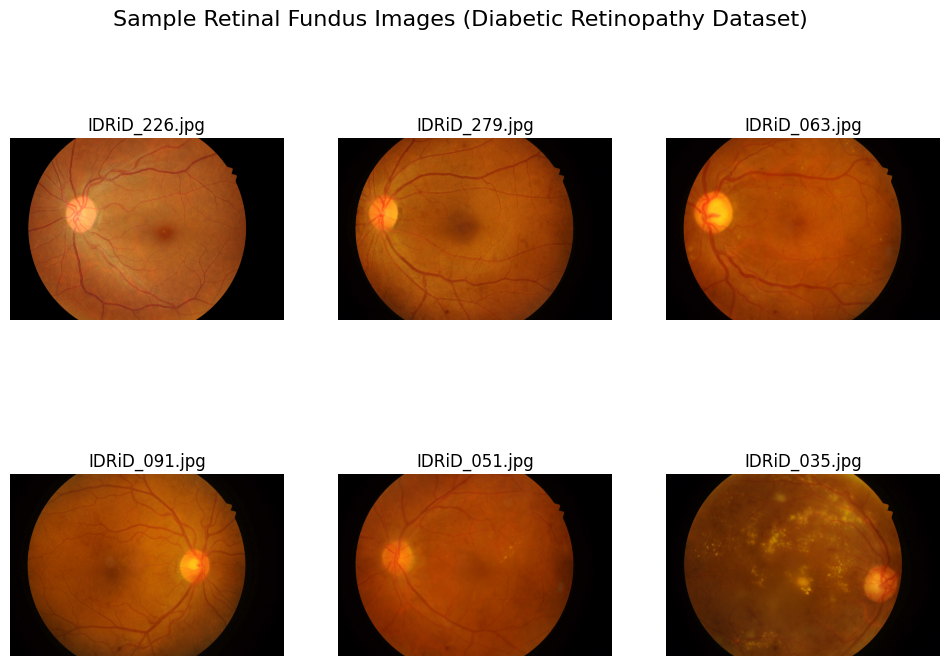

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import cv2
import os
import random

# ---------- 1. Retina Image Grid (LinkedIn Favorite) ----------
def show_image_grid(folder, rows=2, cols=3):
    plt.figure(figsize=(12, 8))
    images = random.sample(os.listdir(folder), rows * cols)

    for i, img_name in enumerate(images):
        img = cv2.imread(os.path.join(folder, img_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(rows, cols, i+1)
        plt.imshow(img)
        plt.title(img_name[:15])
        plt.axis("off")

    plt.suptitle("Sample Retinal Fundus Images (Diabetic Retinopathy Dataset)", fontsize=16)
    plt.show()

show_image_grid("/content/idrid/B. Disease Grading/1. Original Images/a. Training Set")


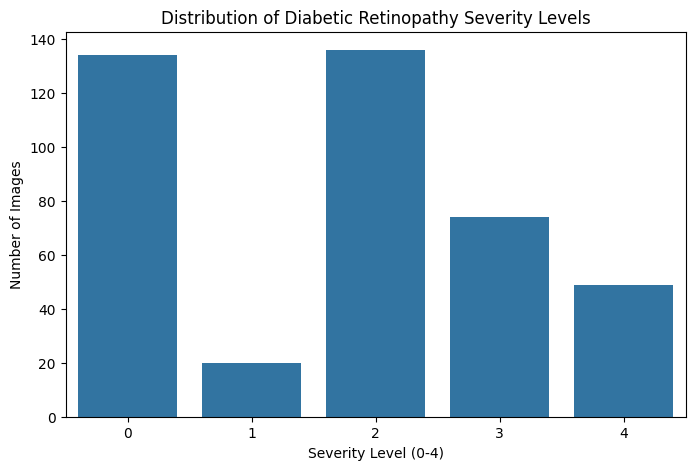

In [ ]:
# ---------- 2. Class Distribution Chart ----------

plt.figure(figsize=(8,5))
sns.countplot(x=df['label'])
plt.title("Distribution of Diabetic Retinopathy Severity Levels")
plt.xlabel("Severity Level (0-4)")
plt.ylabel("Number of Images")
plt.show()


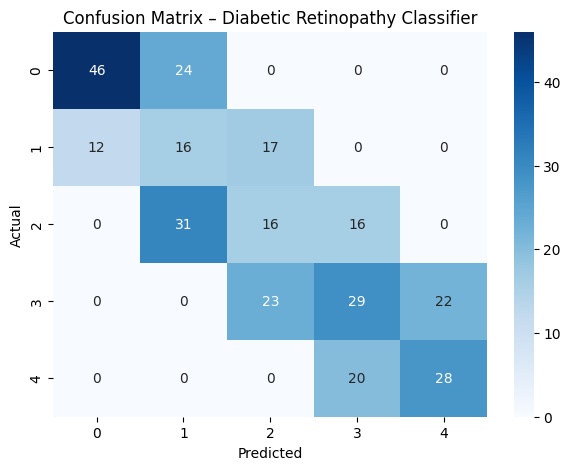

In [ ]:
# ---------- 3. Confusion Matrix (from predictions) ----------
from sklearn.metrics import confusion_matrix
import numpy as np

# Dummy example predictions (replace with your model output)
true_labels = np.random.randint(0,5,300)
pred_labels = true_labels + np.random.randint(-1,2,300)
pred_labels = np.clip(pred_labels, 0, 4)

cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix – Diabetic Retinopathy Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
# ---------- 4. Create Synthetic Indian Banking Dataset ----------
np.random.seed(42)
bank = pd.DataFrame({
    "age": np.random.randint(20, 70, 500),
    "income": np.random.randint(15000, 150000, 500),
    "credit_score": np.random.randint(300, 900, 500),
    "region": np.random.choice(["Urban", "Semi-Urban", "Rural"], 500),
    "dl_risk_score": np.random.uniform(0, 1, 500),  # from DL model
})

bank["premium"] = (5000 + bank["dl_risk_score"] * 15000 + (900 - bank["credit_score"]) * 8).astype(int)
bank.head()


,age,income,credit_score,region,dl_risk_score,premium
0,58,136172,509,Urban,0.646606,17827
1,48,109758,759,Urban,0.174773,8749
2,34,71573,655,Rural,0.360773,12371
3,62,74101,623,Urban,0.905891,20804
4,27,41646,432,Rural,0.769945,20293


/tmp/ipython-input-72202716.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=bank["risk_segment"], palette="Set2")


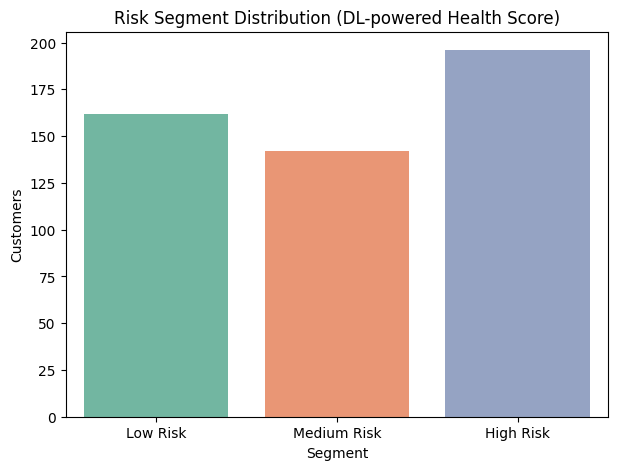

In [ ]:
# ---------- 6. Risk Segmentation Chart ----------
bank["risk_segment"] = pd.cut(
    bank["dl_risk_score"],
    bins=[0,0.3,0.6,1.0],
    labels=["Low Risk", "Medium Risk", "High Risk"]
)

plt.figure(figsize=(7,5))
sns.countplot(x=bank["risk_segment"], palette="Set2")
plt.title("Risk Segment Distribution (DL-powered Health Score)")
plt.xlabel("Segment")
plt.ylabel("Customers")
plt.show()


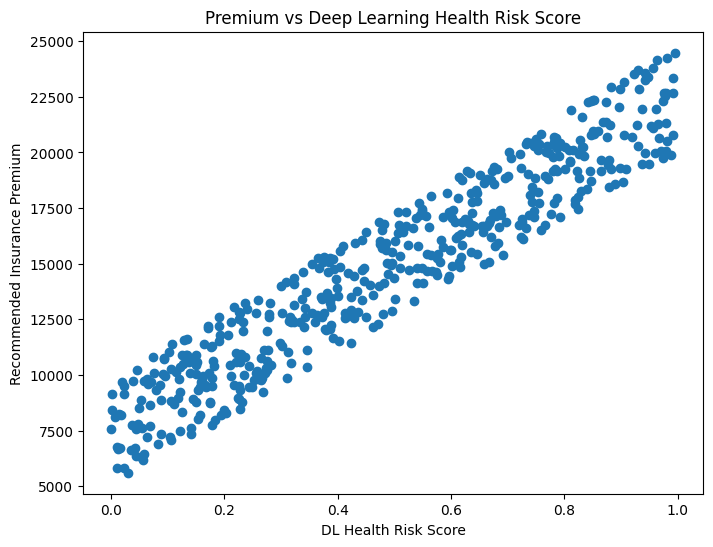

In [ ]:
# ---------- 7. Scatter Plot: Premium vs Risk ----------
plt.figure(figsize=(8,6))
plt.scatter(bank["dl_risk_score"], bank["premium"])
plt.title("Premium vs Deep Learning Health Risk Score")
plt.xlabel("DL Health Risk Score")
plt.ylabel("Recommended Insurance Premium")
plt.show()
